## Chapter 3 Problems
This notebook attempts to solve the problems in Chapter 3 of "Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ Concepts, Tools, and Techniques to Build Intelligent Systems-O'Reilly Media (2022)".

In [1]:
#Import dependencies

import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import tarfile
from pathlib import Path

## Question 1

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

### Create training and test sets

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False) 

/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
some_input = X[0] #this is a 5
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Scale and create classifier
train a KNeighbours classifier using a grid search to find the best hyperparameters

In [4]:

knn_clf = KNeighborsClassifier() #weights and n_neighbours hyperparameters

param_grid = [{'n_neighbors': [3,4,5,6],
               'weights': ['distance']}]

In [5]:
grid_search = GridSearchCV(knn_clf, 
                           param_grid= param_grid,
                           cv = 3,
                           scoring= 'accuracy'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['distance']}],
             scoring='accuracy')

In [6]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.388008,0.045787,13.503045,1.119890,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.97040,0.96890,0.96870,0.969333,0.000759,3
1,0.395728,0.067663,12.637795,0.844099,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.97090,0.96980,0.97035,0.970350,0.000449,1
2,0.343985,0.015807,11.984878,0.186812,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.96880,0.96795,0.96905,0.968600,0.000471,4
3,0.338791,0.006227,12.043371,0.321882,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.97005,0.96855,0.96985,0.969483,0.000665,2


In [63]:
grid_search.score(X_test, y_test) #use .score to return the score using the given data when the best estimator has already been found

0.9714

## Question 2 - Data Augmentation

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.⁠ Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [7]:
def show_digit(input_data):
    image = input_data.reshape(28,28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

def shift(image, direction):
    shifted_image = image.copy()

    if direction == 'down':
    #if shifting down, move values 28 spaces along

        for i in range(len(image)):
            if i<=727:
                shifted_image[i+28] = image[i]
        
        for i in range(28):
            shifted_image[i] = 0

    if direction == 'up':
    #if shifting up, move values 28 spaces behind
        
        for i in range(len(image)):
            if i>=28 and i < 756:
                shifted_image[i-28] = image[i]

            if i >=756:
                shifted_image[i] = 0

    if direction == 'left':
    #if shifting left, move values 1 space back (but not left edge, i.e. multiples of 28)

        for i in range(len(image)):
            if i % 28 != 0:
                shifted_image[i-1] = image[i]
        
        for i in range(28):
            shifted_image[i*28] = 0
        
    if direction == 'right':
    #if shifting right, move values 1 space forward (but not right edge, i.e. 27 + multiples of 28)

        for i in range(len(image)):
            if i % 28 != 27:
                shifted_image[i] = image[i+1]
        
        for i in range(27):
            shifted_image[(i*28)+27] = 0
    
    return shifted_image
            
            


            


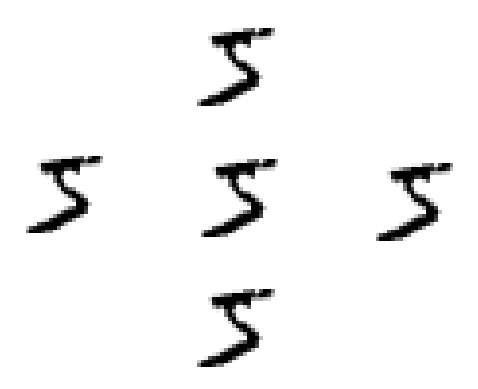

In [45]:
plt.subplot(3,3,5)
show_digit(X[0])
plt.subplot(3,3,8)
show_digit(shift(X[0], 'right'))
plt.subplot(3,3,2)
show_digit(shift(X[0], 'left'))
plt.subplot(3,3,4)
show_digit(shift(X[0], 'up'))
plt.subplot(3,3,6)
show_digit(shift(X[0], 'down'))

In [8]:
def create_shifted_copies(image):
    return shift(image, 'up'), shift(image, 'down'), shift(image, 'left'), shift(image, 'right')

In [9]:
X_train_new = list(X_train.copy())
y_train_new = list(y_train.copy())
for i in range(len(X_train)):
    for shifted_image in create_shifted_copies(X_train[i]):
        X_train_new.append(shifted_image)
        y_train_new.append(y_train[i])
        

In [14]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

In [15]:
#shuffle new training set
shuffle_ids = np.random.permutation(300000)
X_train_new = X_train_new[shuffle_ids]
y_train_new = y_train_new[shuffle_ids]

In [16]:
best_model = grid_search.best_estimator_

In [17]:
best_model.fit(X_train_new, y_train_new)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [19]:
best_model.score(X_test, y_test)

0.975

## Question 3
Using the Titanic dataset. The goal is to train a classifier that can predict the Survived column based on the other columns.

### Visualise the Data

In [3]:
titanic_path = Path('titanic.tgz')
if not titanic_path.is_file():
    with tarfile.open('titanic.tgz') as titanic_tarball:
        titanic_tarball.extractall()

titanic_train = pd.read_csv('titanic/train.csv')
titanic_test = pd.read_csv('titanic/test.csv')

#set the PassengerId column as the index column.
titanic_train = titanic_train.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

In [18]:
pd.DataFrame(titanic_train)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### Cleaning the data: Missingness

In [19]:
#search for missingness across df
titanic_train.isna().sum()
#age and cabin are missing many values

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Would Age be useful for survival? Yes (Since children are prioritised). How might we predict the age? Age might be related to passenger fare and, ticket class, and small chance of being related to number of children/siblings (if there are significant differences between generations). Maybe use a KNN imputer?

Would Cabin be useful for survival? Maybe type of cabin? Many values are NaN so maybe don't use this feature

In [41]:
#get rid of irrelevant columns and cabin
tit_X_train = titanic_train.drop(titanic_train.columns[[0,2,7,9]], axis=1)

#keep survived column
tit_y_train = titanic_train.iloc[:,0]

rel_indices = tit_X_train['Embarked'].notna().to_numpy().astype(bool)
tit_X_train = tit_X_train.iloc[rel_indices,:]
tit_y_train = tit_y_train.iloc[rel_indices]

#impute ages with KNN value
def round_to_pandas(values):
    rounded_values = np.round(values)
    return pd.DataFrame(rounded_values)

num_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('round', FunctionTransformer(round_to_pandas, feature_names_out='one-to-one')),
])

#create cat pipeline for one hot encoding
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
                             SimpleImputer(strategy='most_frequent'))

#build a preprocessing pipeline that will be fit-transformed as part of the final pipeline
preprocessing = ColumnTransformer([
    ('num', num_pipeline, ['Age','Fare']),
    ('one_hot', cat_pipeline, ['Sex', 'Pclass', 'Embarked']),
], remainder = 'passthrough')


In [42]:
tit_X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
887,2,male,27.0,0,0,13.0000,S
888,1,female,19.0,0,0,30.0000,S
889,3,female,NaN,1,2,23.4500,S


In [43]:
#try building a random forest? transformation as part of the preprocessing means you can keep reusing the base training set
titanic_forest = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestClassifier(random_state=1610))])

In [44]:
param_distribs = {'preprocessing__num__impute__n_neighbors': randint(low=3, high=20)}

In [45]:
#find the best model. 
forest_rand_srch = RandomizedSearchCV(titanic_forest, param_distributions=param_distribs, n_iter=10,
                                      cv=5)
forest_rand_srch.fit(tit_X_train, tit_y_train)
forest_estimator = forest_rand_srch.best_estimator_

In [46]:
forest_rand_srch.best_params_


{'preprocessing__num__impute__n_neighbors': 15}

In [47]:
y_pred = cross_val_predict(forest_estimator, tit_X_train, tit_y_train, cv=3)

In [48]:
print(confusion_matrix(tit_y_train, y_pred))
print("accuracy score is", accuracy_score(tit_y_train, y_pred)) #how many times is the classifier right?
print("precision score is", precision_score(tit_y_train, y_pred)) #true positives over false and true positives - how often is it the class the classifier claimed it to be?
print("recall score is", recall_score(tit_y_train, y_pred)) # true positives over false negatives and true positives - when it is actually a class, how often does the classifier get it?

[[466  83]
 [ 97 243]]
accuracy score is 0.7975253093363329
precision score is 0.745398773006135
recall score is 0.7147058823529412


What if we mess around with the threshold probabilities?

In [49]:
y_pred_probs = cross_val_predict(titanic_forest, tit_X_train, tit_y_train, cv=3, method = 'predict_proba')
y_pred_60 = [0 if i[0] > 0.6 else 1 for i in y_pred_probs]

In [50]:
print(confusion_matrix(tit_y_train, y_pred_60))
print("accuracy score is", accuracy_score(tit_y_train, y_pred_60)) 
print("precision score is", precision_score(tit_y_train, y_pred_60)) #worse accuracy and precision
print("recall score is", recall_score(tit_y_train, y_pred_60)) #better recall

[[432 117]
 [ 87 253]]
accuracy score is 0.7705286839145107
precision score is 0.6837837837837838
recall score is 0.7441176470588236


Let's try a different classifier. SGD?

In [51]:
sgd_clf = Pipeline([
    ('preprocessing', preprocessing),
    ('sgd', SGDClassifier(random_state=1610))
])


rand_sgd = RandomizedSearchCV(sgd_clf, param_distributions=param_distribs, cv=5, n_iter=10)
rand_sgd.fit(tit_X_train, tit_y_train)
rand_sgd_est = rand_sgd.best_estimator_

In [52]:
y_sgd_pred = cross_val_predict(rand_sgd_est, tit_X_train, tit_y_train, cv=3)

In [53]:
print(confusion_matrix(tit_y_train, y_sgd_pred))
print("accuracy score is", accuracy_score(tit_y_train, y_sgd_pred)) 
print("precision score is", precision_score(tit_y_train, y_sgd_pred)) #worse accuracy and precision
print("recall score is", recall_score(tit_y_train, y_sgd_pred)) #better recall

[[473  76]
 [174 166]]
accuracy score is 0.718785151856018
precision score is 0.6859504132231405
recall score is 0.48823529411764705


Try SVC.

In [54]:
svc_clf = Pipeline([
    ('preprocessing', preprocessing),
    ('svc', SVC(random_state=1610, gamma= 'auto'))
])

rnd_svc = RandomizedSearchCV(svc_clf, param_distributions=param_distribs, n_iter=10, cv=5)
rnd_svc.fit(tit_X_train, tit_y_train)
svc_estimator = rnd_svc.best_estimator_

In [55]:
y_svc_pred = cross_val_predict(svc_estimator, tit_X_train, tit_y_train, cv=10)

In [56]:
print(confusion_matrix(tit_y_train, y_svc_pred))
print("accuracy score is", accuracy_score(tit_y_train, y_svc_pred)) 
print("precision score is", precision_score(tit_y_train, y_svc_pred)) #worse accuracy and precision
print("recall score is", recall_score(tit_y_train, y_svc_pred)) #better recall

[[445 104]
 [137 203]]
accuracy score is 0.7289088863892014
precision score is 0.6612377850162866
recall score is 0.5970588235294118


Create predictions for test data.

In [57]:
titanic_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [58]:
#get rid of irrelevant columns and cabin
tit_X_test = titanic_test.drop(titanic_test.columns[[1,6,8]], axis=1)
tit_X_test


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,S
1306,1,female,39.0,0,0,108.9000,C
1307,3,male,38.5,0,0,7.2500,S


In [61]:
tit_X_test_processed = forest_estimator[0].transform(tit_X_test)
tit_X_test_processed = pd.DataFrame(tit_X_test_processed, index=tit_X_test.index)
tit_X_test_processed

,0,1,2,3,4,5,6,7,8,9,10,11
PassengerId,,,,,,,,,,,,
892,34.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
893,47.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
894,62.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
895,27.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
896,22.0,12.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,29.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1306,39.0,109.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1307,38.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [67]:
tit_test_y_preds = forest_estimator[1].predict(tit_X_test_processed)
tit_test_y_preds = pd.DataFrame(tit_test_y_preds, columns=['Survived'], index=tit_X_test.index)

In [69]:
tit_test_y_preds.to_csv('titanic_test_predictions.csv')